In [1]:
import json

from corebreakout.datasets import PolygonDataset

from mrcnn.model import log
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances

Using TensorFlow backend.


# Load and prepare a dataset:

Here we're using the small two image dataset in `tests/data` to illustrate what's going on with our annotations and labels. You can change the directories to point to `assets/data` if you've downloaded `assets.zip` want to check out the whole training or testing dataset provided.

Note that the background class, `'BG'` is always added as the first class, with `class_id=0`. You never need to label the background -- it's just assumed to be everywhere that there's no labeled objects.

In [2]:
DATA_LOCATION = '../tests/data/'
DATA_SUBDIR = 'two_image_dataset'

dataset = PolygonDataset(classes=['col', 'tray'])
dataset.collect_annotated_images(DATA_LOCATION, DATA_SUBDIR)
dataset.prepare()

print(dataset)


 PolygonDataset
Image count : 2
Class count : 3
  0. BG                                                
  1. col                                               
  2. tray                                              


The `Dataset` collects a list relevant metadata for each image:

In [3]:
dataset.image_info

[{'id': 'S00101409',
  'source': 'cb',
  'path': PosixPath('../tests/data/two_image_dataset/S00101409.jpeg'),
  'ann_path': PosixPath('../tests/data/two_image_dataset/S00101409.json')},
 {'id': 'S00111582',
  'source': 'cb',
  'path': PosixPath('../tests/data/two_image_dataset/S00111582.jpeg'),
  'ann_path': PosixPath('../tests/data/two_image_dataset/S00111582.json')}]

In [4]:
dataset.class_info

[{'source': '', 'id': 0, 'name': 'BG'},
 {'source': 'cb', 'id': 1, 'name': 'col'},
 {'source': 'cb', 'id': 2, 'name': 'tray'}]

**Note**: the `'source'` is irrelevant unless you're using multiple distinct datasets with different characteristics or annotation formats that you want to combine and use simultaneously. `'cb'` is just our placeholder, and `corebreakout.PolygonDataset` is designed as an API for single-source datasets.

# A look at the raw annotations:

In [5]:
img_idx = 0

ann_path = dataset.image_info[img_idx]["ann_path"]

with open(ann_path, "r") as ann_file:
    ann_json = json.load(ann_file)
    
# The individual polygons are stored under 'shapes'
shapes = ann_json['shapes']

# Each shape has various attributes
shapes[0].keys()

dict_keys(['label', 'line_color', 'fill_color', 'points', 'shape_type', 'flags'])

The `flags` and `_color` fields are `null`, and the `shape_type` is just `'polygon'`. You don't need to do anything extra to set any of these fields as a user of `labelme`.

The `points` field stores the vertices of the polygon, and the `label` field holds the **user-specified** text label for that polygon:

In [6]:
for s in shapes:
    print('label:  ', s['label'])

label:   col1
label:   col2
label:   tray1


So this image contains two instances of the `'col'` class, and one instance of the `'tray'` class.

**These are the labels entered in `labelme`**, and you can see that they follow guidelines from the documentation page [Creating Datasets](https://corebreakout.readthedocs.io/en/latest/creating_datasets.html): Each polygon is given a label that starts with the class name (*e.g.*, `'col'` or `'tray'`), and then a differentiating character at the end (*e.g.*, `'1'` or `'2'`).

The `Polygon.load_mask()` method handles converting polygons to masks, and converts annotation `label`s to the corresponding `class_id`s.

# Visualizing the annotations:

Typically, you don't need to call `load` methods yourself (*e.g.*, to train models you just call `model.train(train_dataset, test_dataset, ...)`, and then the rest is done under the hood), but here we'll manually load an images and masks to display:

In [7]:
# Convenience map from class_ids -> colors ('col' and 'tray', respectively)
colors = [(0,0,1), (0,1,0)]
id2color = lambda i : colors[i-1]

image_id  0 ../tests/data/two_image_dataset/S00101409.jpeg
image                    shape: (4757, 7105, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (4757, 7105, 3)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    2.00000  int64


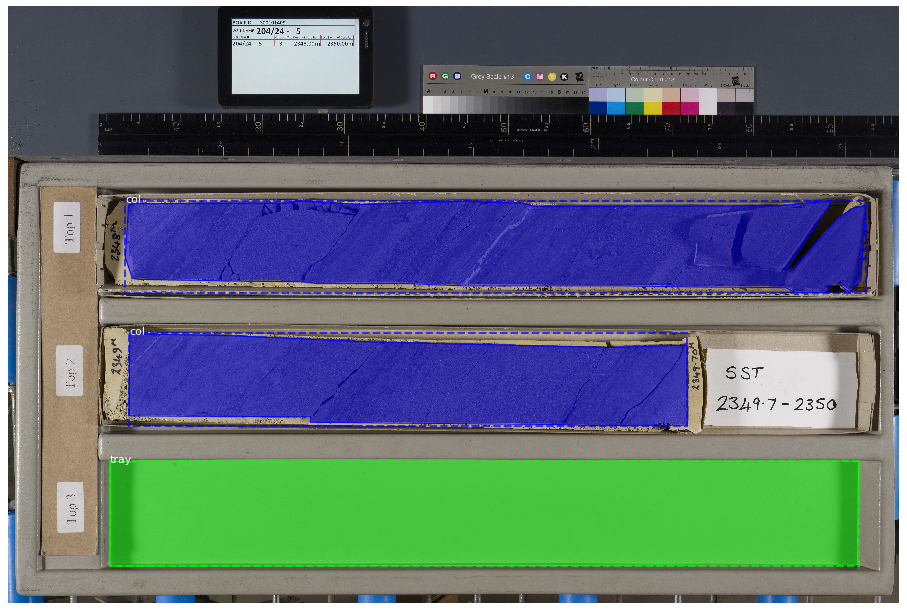

In [8]:
img_idx = 0

# Load the image -- simple enough
img = dataset.load_image(img_idx)

# Load json annotations, then return: 
#     - (H,W,C) boolean `masks` array with same HxW as `img`, and C=number of shapes
#     - vector of integers giving the `class_id` corresponding to each channel in `masks`
masks, class_ids = dataset.load_mask(img_idx)

# Bounding boxes are computed from masks on the fly
bboxes = extract_bboxes(masks)

# Display image and additional stats
print("image_id ", img_idx, dataset.image_reference(img_idx))
log("image", img)
log("mask", masks)
log("class_ids", class_ids)

# Display image and instances
display_instances(img, bboxes, masks, class_ids, dataset.class_names, 
                  colors=[id2color(i) for i in class_ids])

Just for fun, we can do the second image too:

image_id  1 ../tests/data/two_image_dataset/S00111582.jpeg
image                    shape: (4725, 7096, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (4725, 7096, 3)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    2.00000  int64


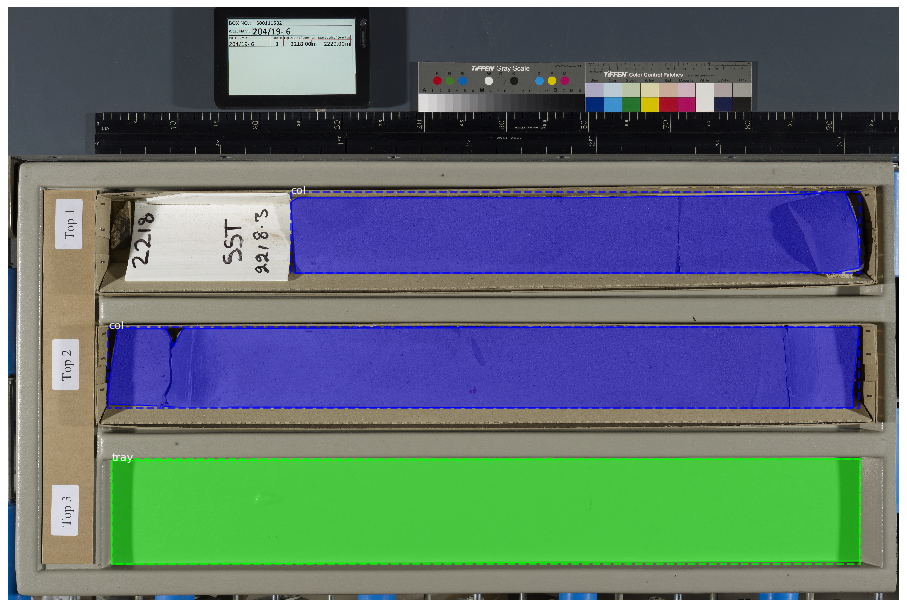

In [9]:
img_idx = 1

img, (masks, class_ids) = dataset.load_image(img_idx), dataset.load_mask(img_idx)

# Compute bounding boxes from masks
bboxes = extract_bboxes(masks)

# Display image and additional stats
print("image_id ", img_idx, dataset.image_reference(img_idx))
log("image", img)
log("mask", masks)
log("class_ids", class_ids)

# Display image and instances
display_instances(img, bboxes, masks, class_ids, dataset.class_names, 
                  colors=[id2color(i) for i in class_ids])